# 18. Correlating on Personality Index (Frame selection)

In [1]:
from src import *
import warnings
warnings.filterwarnings("ignore")

## Description

We correlate gradients with personality index

GOAL: Evaluating correlation level with personality index

## Table of Contents

- [Correlation evaluation](#correval)



In [43]:
# Loading behavioural scores
behavioural  = pd.read_excel('./data/labels/Behavioural_PSY_scored.xlsx')
existing_psy = list(behavioural.columns[-15:])

regions      = list(index2region.keys())
print(regions)

['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default', 'Sub']


<a class="anchor" id="correval"></a>
## Correlation evaluation

#### Visual difference

In [14]:
# Params
embedding  = "dm" # diffusion map
aff_kernel = "pearson" #affinity matrix kernel
nb_comp    = 3
rs         = 99

D = lambda x,y: ((x-y)**2).sum(axis=1)

In [216]:
total_series = load('./data/fmri_414_series.pkl')
f_series = load('./resources/treshed_series.pkl')

if 'Rest' in total_series: del total_series['Rest']
if 'Rest' in f_series: del f_series['Rest']

In [275]:
s30 = [(s,s+30) for s in range(0,101,10) if (s+30 <= 100)]
s40 = [(s,s+40) for s in range(0,101,10) if (s+40 <= 100)]

In [341]:
all_fselect_gradients = {}
for bound in s30:
    fselected_series = f_series[1][bound]
    fselect_subjects = {_id:[] for _id in fselected_series['Sintel'].keys()}
    # array swap
    for mname in fselected_series:
        tmp_dict = fselected_series[mname]

        for _id in tmp_dict:
            tmp_series = tmp_dict[_id]
            fselect_subjects[_id].append(tmp_series)

    # fselect gradients compute
    fselect_gradients = {}
    for _id in fselect_subjects:
        tmp_series = np.concatenate(fselect_subjects[_id])
        fc_select = FC(tmp_series)
        g_select = GradientMaps(n_components=nb_comp, approach=embedding, 
                                kernel=aff_kernel, random_state=rs)
        g_select.fit(fc_select)
        grad = g_select.gradients_

        fscore = D(grad.mean(axis=0), grad)
        fselect_gradients[_id] = fscore
    
    all_fselect_gradients[bound] = fselect_gradients

In [76]:
fmovie_subjects = {_id:[] for _id in total_series['Sintel'].keys()}
# array swap
for mname in total_series:
    tmp_dict = total_series[mname]
    
    for _id in tmp_dict:
        tmp_series = tmp_dict[_id]
        fmovie_subjects[_id].append(tmp_series)
        
# all movies gradients compute
fmovie_gradients = {}
for _id in fmovie_subjects:
    tmp_series = np.concatenate(fmovie_subjects[_id])
    fc_movie = FC(tmp_series)
    g_movie = GradientMaps(n_components=nb_comp, approach=embedding, 
                            kernel=aff_kernel, random_state=rs)
    g_movie.fit(fc_movie)
    grad = g_movie.gradients_
    
    fscore = D(grad.mean(axis=0), grad)
    fmovie_gradients[_id] = fscore

In [330]:
frandom_subjects = {_id:[] for _id in total_series['Sintel'].keys()}
# array swap
for mname in total_series:
    tmp_dict = total_series[mname]
    tmp = tmp_dict[next(iter(tmp_dict))]
    perc_left = tmp.shape[0]*30//100
    start_idx = np.random.choice(np.arange(tmp.shape[0]-perc_left))
    
    for _id in tmp_dict:
        tmp_series = tmp_dict[_id][start_idx:start_idx+perc_left]
        frandom_subjects[_id].append(tmp_series)
        
# all movies gradients compute
frandom_gradients = {}
for _id in frandom_subjects:
    tmp_series = np.concatenate(frandom_subjects[_id])
    fc_random = FC(tmp_series)
    g_random = GradientMaps(n_components=nb_comp, approach=embedding, 
                            kernel=aff_kernel, random_state=rs)
    g_random.fit(fc_random)
    grad = g_random.gradients_
    
    fscore = D(grad.mean(axis=0), grad)
    frandom_gradients[_id] = fscore

### Correlation Computation Full Gradients

All film versus one chosen bound

In [331]:
# eg choice for fselect
fselect_gradients = all_fselect_gradients[(70,100)]

In [332]:
subjects = list(fmovie_gradients.keys())

In [333]:
fmovie_array = np.asarray([frandom_gradients[sub] for sub in subjects])
fselect_array = np.asarray([fselect_gradients[sub] for sub in subjects])

In [334]:
pred_distrib_select1 = {'pidx': [], 'foldcorr': []}
pred_distrib_select2 = {'pidx': [], 'foldcorr': []}
pred_distrib_movie1 = {'pidx': [], 'foldcorr': []}
pred_distrib_movie2 = {'pidx': [], 'foldcorr': []}

for k in range(len(existing_psy)):
    feat = existing_psy[k]
    psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]
    fmovie_corr = [pearson_correlation(fmovie_array[:,i], psyscore) for i in range(fmovie_array.shape[1])]
    fselect_corr = [pearson_correlation(fselect_array[:,i], psyscore) for i in range(fselect_array.shape[1])]
    
    if k <= (len(existing_psy)/2):    
        pred_distrib_movie1['foldcorr'] += list(np.abs(fmovie_corr))
        pred_distrib_select1['foldcorr'] += list(np.abs(fselect_corr))
        pred_distrib_movie1['pidx'] += len(fmovie_corr) * [feat]
        pred_distrib_select1['pidx'] += len(fselect_corr) * [feat]
    else:
        pred_distrib_movie2['foldcorr'] += list(np.abs(fmovie_corr))
        pred_distrib_select2['foldcorr'] += list(np.abs(fselect_corr))
        pred_distrib_movie2['pidx'] += len(fmovie_corr) * [feat]
        pred_distrib_select2['pidx'] += len(fselect_corr) * [feat]
        
pred_movie1_df = pd.DataFrame.from_dict(pred_distrib_movie1)
pred_movie2_df = pd.DataFrame.from_dict(pred_distrib_movie2)

pred_select1_df = pd.DataFrame.from_dict(pred_distrib_select1)
pred_select2_df = pd.DataFrame.from_dict(pred_distrib_select2)

<Figure size 1400x500 with 0 Axes>

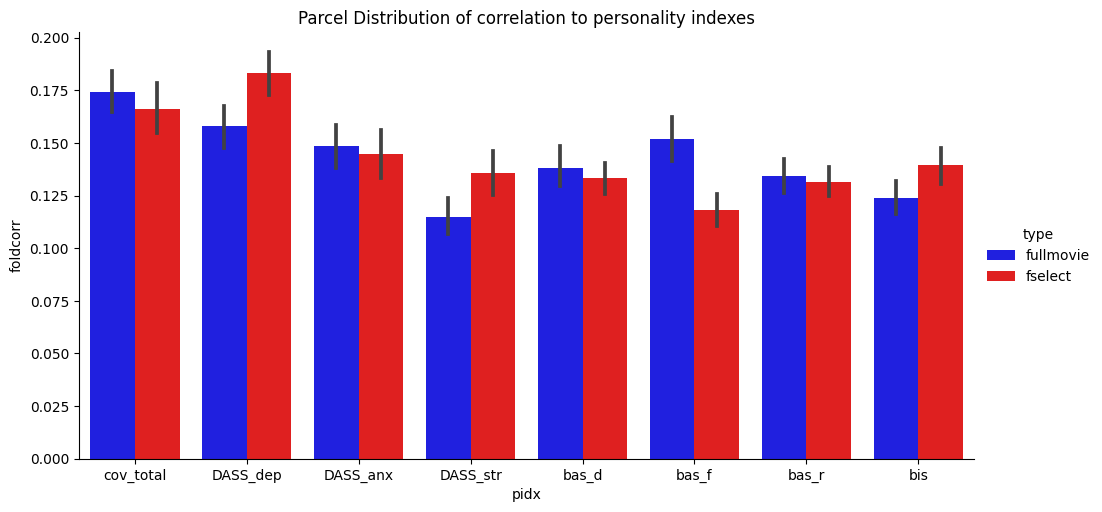

In [335]:
pred_select1_df['type'] = 'fselect'
pred_movie1_df['type'] = 'fullmovie'
tmp_df = pd.concat([pred_movie1_df, pred_select1_df])
plt.figure(figsize=(14,5))
sns.catplot(x='pidx', y='foldcorr', hue='type', data=tmp_df,kind='bar', height=5, aspect=2, palette=sns.color_palette(['blue', 'red']))
# sns.barplot(x="pidx", y="foldcorr", data=pred_select1_df, capsize=0.05,errorbar="sd", color='r', alpha=0.3, label='fselect')
# sns.barplot(x="pidx", y="foldcorr", data=pred_movie1_df, capsize=0.05,errorbar="sd", color='b', alpha=0.3, label='fullmovie')
# sns.swarmplot(x="pidx", y="foldcorr", data=pred_distrib_select1, color="r", alpha=.4, size=3, label='fselect')
# sns.swarmplot(x="pidx", y="foldcorr", data=pred_distrib_movie1, color="b", alpha=.4, size=3, label='fullmovie')
plt.title("Parcel Distribution of correlation to personality indexes")

# remove duplicate legend
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())

plt.show()

<Figure size 1400x500 with 0 Axes>

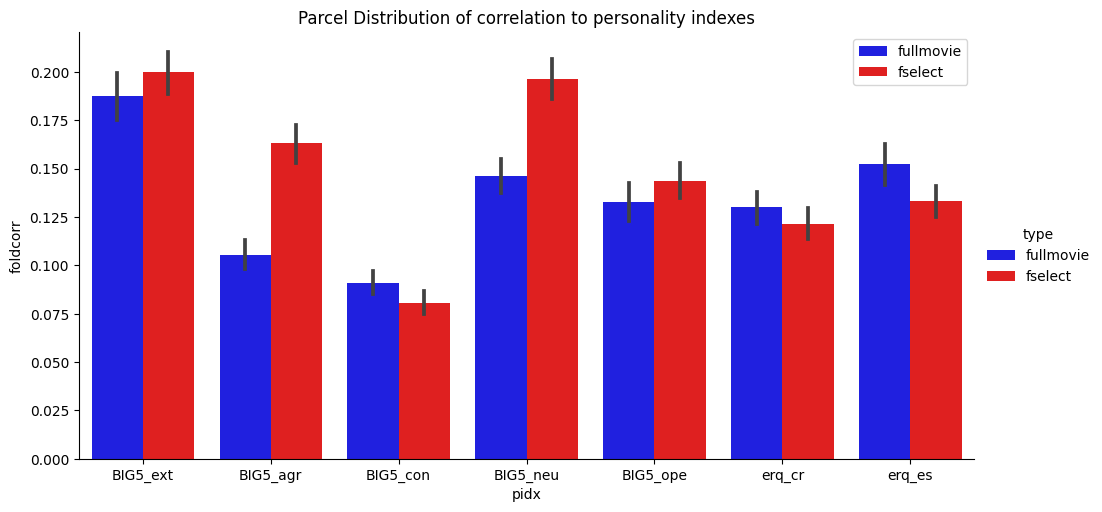

In [336]:
pred_select2_df['type'] = 'fselect'
pred_movie2_df['type'] = 'fullmovie'
tmp_df = pd.concat([pred_movie2_df, pred_select2_df])

plt.figure(figsize=(14,5))
sns.catplot(x='pidx', y='foldcorr', hue='type', data=tmp_df, 
            kind='bar', height=5, aspect=2, palette=sns.color_palette(['blue', 'red']))
# sns.barplot(x="pidx", y="foldcorr", data=pred_distrib_select2, capsize=0.05,errorbar="sd", color='r', alpha=0.3, label='fselect')
# sns.barplot(x="pidx", y="foldcorr", data=pred_distrib_movie2, capsize=0.05,errorbar="sd", color='b', alpha=0.3, label='fullmovie')
# sns.swarmplot(x="pidx", y="foldcorr", data=pred_distrib_select2, color="r", alpha=.4, size=3, label='fselect')
# sns.swarmplot(x="pidx", y="foldcorr", data=pred_distrib_movie2, color="b", alpha=.4, size=3, label='fullmovie')
plt.title("Parcel Distribution of correlation to personality indexes")

# remove duplicate legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()

In [340]:
# quick paired t-test
tmp1 = pred_movie2_df[pred_movie2_df['pidx'] == 'erq_es']['foldcorr'].values
tmp2 = pred_select2_df[pred_select2_df['pidx'] == 'erq_es']['foldcorr'].values

print(stats.ttest_ind(tmp1, tmp2))
print(stats.wilcoxon(tmp1-tmp2))

Ttest_indResult(statistic=2.7047107430599113, pvalue=0.00697711353017662)
WilcoxonResult(statistic=33107.0, pvalue=5.311179339937173e-05)


In [338]:
np.mean(tmp1), np.mean(tmp2)

(0.13257909758562733, 0.14341636383369535)

Across different bounds of frame selection

In [342]:
all_array = np.asarray([[all_fselect_gradients[s][sub] for sub in subjects] for s in s30])

In [345]:
pred_distrib_selects = {'pidx': [], 'foldcorr': [], 'type': []}

for k in range(len(existing_psy)):
    feat = existing_psy[k]
    psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]
    all_corr = [[pearson_correlation(all_array[k,:,i], psyscore) for i in range(414)] 
                for k in range(len(all_array))]
    
    for k in range(len(all_corr)):
        pred_distrib_selects['foldcorr'] += list(np.abs(all_corr[k]))
        pred_distrib_selects['pidx'] += len(all_corr[k]) * [feat]
        pred_distrib_selects['type'] += len(all_corr[k]) * [s30[k]]

pred_selects_df = pd.DataFrame.from_dict(pred_distrib_selects)

<Figure size 1400x500 with 0 Axes>

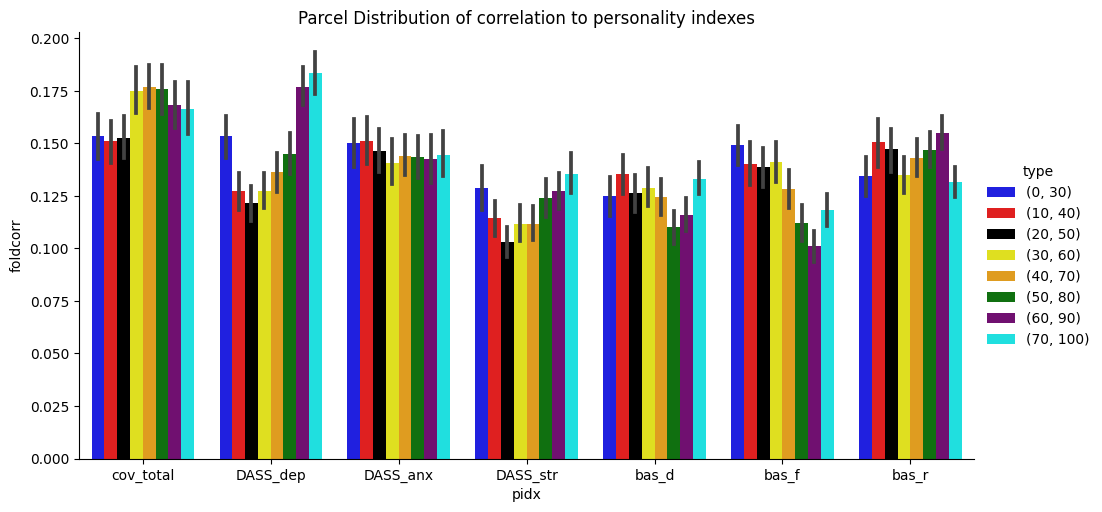

In [354]:
plt.figure(figsize=(14,5))
sns.catplot(x='pidx', y='foldcorr', hue='type', data=pred_selects_df[pred_selects_df['pidx'].isin(existing_psy[:len(existing_psy)//2])], 
            kind='bar', height=5, aspect=2, palette=sns.color_palette(['blue', 'red', 'black', 
                                                                       'yellow', 'orange', 'green',
                                                                      'purple', 'cyan']))
plt.title("Parcel Distribution of correlation to personality indexes")

plt.show()

<Figure size 1400x500 with 0 Axes>

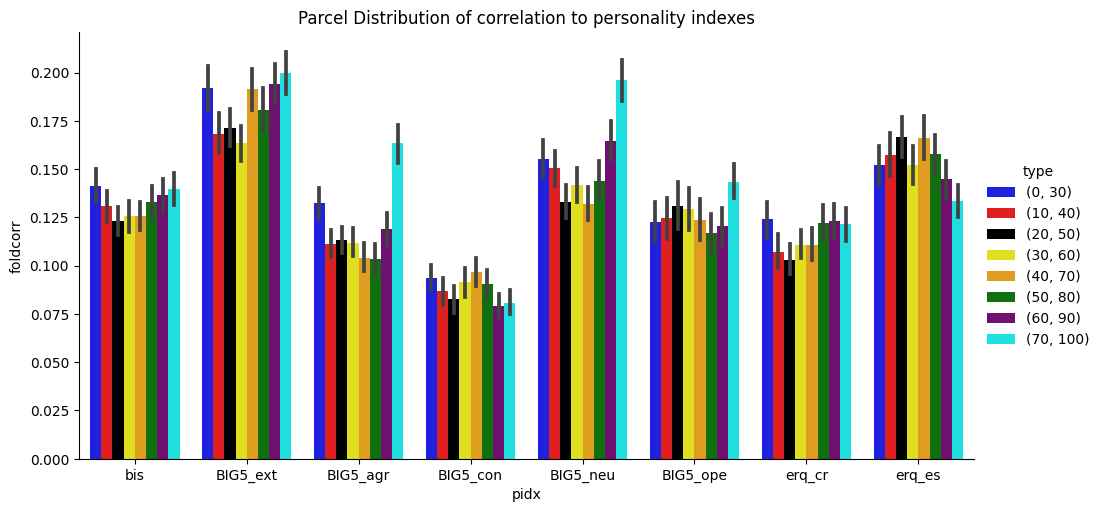

In [355]:
plt.figure(figsize=(14,5))
sns.catplot(x='pidx', y='foldcorr', hue='type', data=pred_selects_df[pred_selects_df['pidx'].isin(existing_psy[len(existing_psy)//2:])], 
            kind='bar', height=5, aspect=2, palette=sns.color_palette(['blue', 'red', 'black', 
                                                                       'yellow', 'orange', 'green',
                                                                      'purple', 'cyan']))
plt.title("Parcel Distribution of correlation to personality indexes")

plt.show()

### Network level

In [356]:
all_array = np.asarray([[all_fselect_gradients[s][sub] for sub in subjects] for s in s30])

In [367]:
net = 'Limbic'

In [368]:
pred_distrib_selects = {'pidx': [], 'foldcorr': [], 'type': []}

for k in range(len(existing_psy)):
    feat = existing_psy[k]
    psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]
    all_corr = [[pearson_correlation(all_array[k,:,i], psyscore) for i in index2region[net]] 
                for k in range(len(all_array))]
    
    for k in range(len(all_corr)):
        pred_distrib_selects['foldcorr'] += list(np.abs(all_corr[k]))
        pred_distrib_selects['pidx'] += len(all_corr[k]) * [feat]
        pred_distrib_selects['type'] += len(all_corr[k]) * [s30[k]]

pred_selects_df = pd.DataFrame.from_dict(pred_distrib_selects)

<Figure size 1400x500 with 0 Axes>

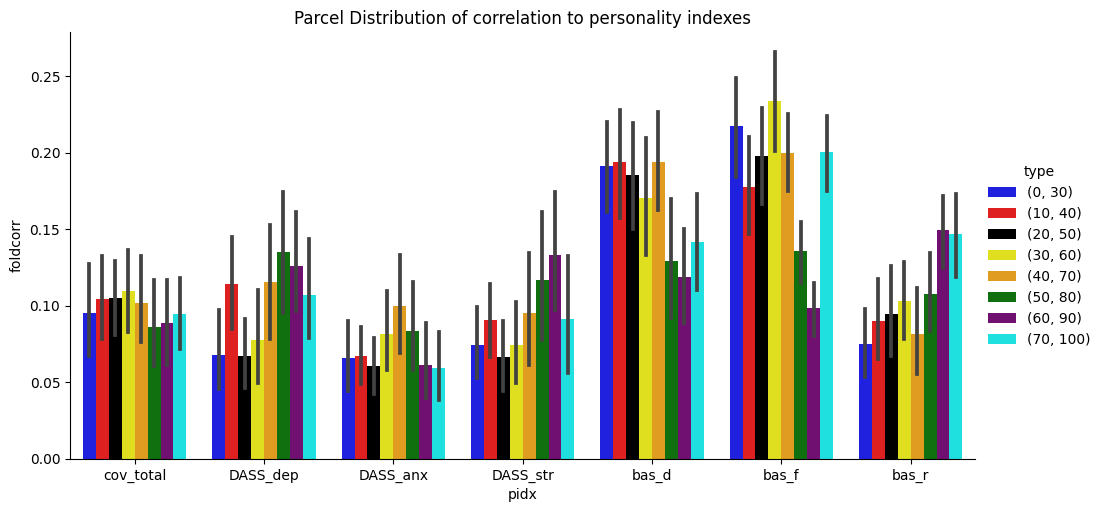

In [369]:
plt.figure(figsize=(14,5))
sns.catplot(x='pidx', y='foldcorr', hue='type', data=pred_selects_df[pred_selects_df['pidx'].isin(existing_psy[:len(existing_psy)//2])], 
            kind='bar', height=5, aspect=2, palette=sns.color_palette(['blue', 'red', 'black', 
                                                                       'yellow', 'orange', 'green',
                                                                      'purple', 'cyan']))
plt.title("Parcel Distribution of correlation to personality indexes")

plt.show()

<Figure size 1400x500 with 0 Axes>

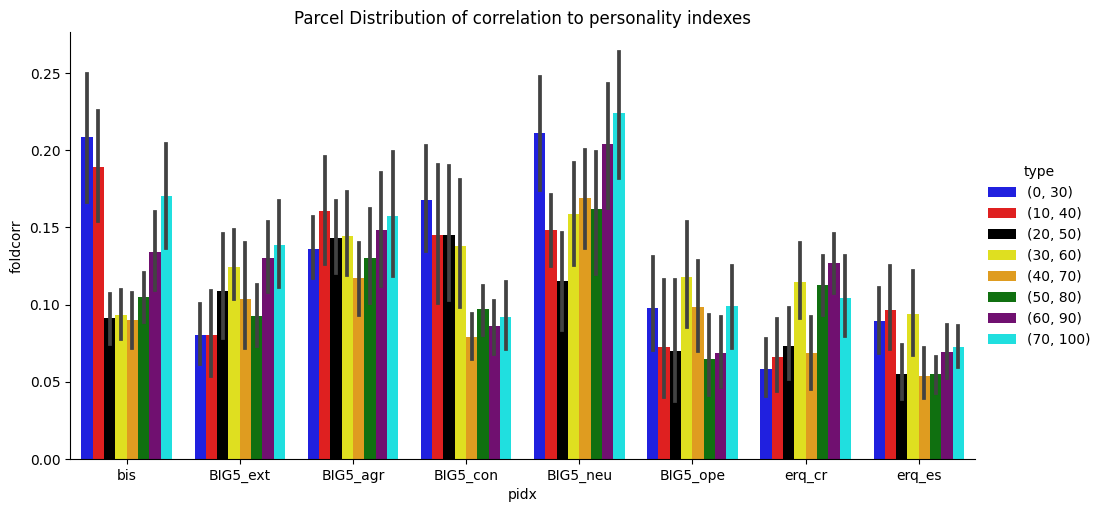

In [370]:
plt.figure(figsize=(14,5))
sns.catplot(x='pidx', y='foldcorr', hue='type', data=pred_selects_df[pred_selects_df['pidx'].isin(existing_psy[len(existing_psy)//2:])], 
            kind='bar', height=5, aspect=2, palette=sns.color_palette(['blue', 'red', 'black', 
                                                                       'yellow', 'orange', 'green',
                                                                      'purple', 'cyan']))
plt.title("Parcel Distribution of correlation to personality indexes")

plt.show()